<a href="https://colab.research.google.com/github/sankardevisharath/amex-default-prediction/blob/master/notebooks/GRU_Ensemble_With_Complete_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from os import listdir

files = listdir('/content/drive/MyDrive/amex-default-prediction/data/customer_train/')


In [2]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import gc 

import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import tensorflow as tf
from keras.layers import GRU, Dense
import tensorflow_addons as tfa


In [4]:
cat_cols = ['D_63', 'D_64','B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68']
TRAIN_LABELS_PATH = '/content/train_labels.csv'
AGG_DATA_ABS_PATH = '/content/drive/MyDrive/amex-default-prediction/data/aggr/customer-agg.parquet'

In [5]:
!unzip -o /content/drive/MyDrive/amex-default-prediction/data/amex-default-prediction.zip \
 train_labels.csv

Archive:  /content/drive/MyDrive/amex-default-prediction/data/amex-default-prediction.zip
  inflating: train_labels.csv        


In [6]:
train_labels = pd.read_csv(TRAIN_LABELS_PATH)

In [7]:
train_labels.shape

(458913, 2)

In [8]:
agg_dataset = pd.read_parquet(path=AGG_DATA_ABS_PATH)

In [9]:
enc_agg = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
agg_dataset[['D_63_last', 'D_64_last']]=enc_agg.fit(agg_dataset[['D_63_last', 'D_64_last']])
agg_dataset[['D_63_last', 'D_64_last']]=enc_agg.transform(agg_dataset[['D_63_last', 'D_64_last']])
agg_dataset.fillna(0, inplace=True)



In [10]:
agg_dataset.drop(axis=1, columns=['target'], inplace=True)

In [11]:
agg_dataset.shape

(458913, 919)

In [12]:
def append_label(source_df):
  return pd.merge(left=source_df, right=train_labels, how='inner')

In [13]:
def my_generator():
    for f in files:      
      X = pd.DataFrame()
      Y = pd.DataFrame()
      df_tmp = pd.read_parquet('/content/drive/MyDrive/amex-default-prediction/data/customer_train/' + f)
      df_tmp = append_label(df_tmp)
      enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
      df_tmp[['D_63', 'D_64']]=enc.fit(df_tmp[['D_63', 'D_64']])

      df_tmp[['D_63', 'D_64']]=enc.transform(df_tmp[['D_63', 'D_64']])
      df_tmp.fillna(0, inplace=True)

      X= X.append(df_tmp.loc[:, ~df_tmp.columns.isin(['target'])])
      X = X[X.groupby('customer_ID')['customer_ID'].transform('count') == 13]
      X_Cust = pd.DataFrame(X['customer_ID'].unique(), columns=['customer_ID'])
      Y = pd.merge(left=X_Cust, right=train_labels, how='inner')

      X_Agg = pd.merge(left=X_Cust, right=agg_dataset, how ='inner')
      
      X.drop(axis=1, columns=['customer_ID', 'S_2'], inplace=True)
      X = X.values.reshape(X_Cust.shape[0], 13, 188)
      Y.drop(axis=1, columns='customer_ID', inplace=True)

      X_Agg.drop(axis=1, columns='customer_ID', inplace=True)

      print(f'X shape = {X.shape}')
      yield {"input_1": X, "input_2": X_Agg.to_numpy()}, Y.to_numpy()
      




In [14]:
def my_input_fn(epochs):
    dataset = tf.data.Dataset.from_generator(lambda: my_generator(),
                                             output_types=({"input_1": tf.float64, "input_2": tf.float64}, tf.int64),
                                            output_shapes=({"input_1": tf.TensorShape([None, 13, 188]), "input_2" : tf.TensorShape([None, 918])},
                                                           tf.TensorShape([None, 1])))

    dataset = dataset.repeat(epochs)
    # dataset = dataset.batch(32)
    return dataset


In [ ]:
f1_metric = tfa.metrics.F1Score(num_classes=1, threshold=0.5)

gru_model = tf.keras.Sequential()
input_1 = tf.keras.Input(shape=(13, 188))
gru_model.add(input_1)
gru_model.add(GRU(64, dropout=0.1, recurrent_dropout=0.5))


agg_model = tf.keras.Sequential()
input_2 = tf.keras.Input(shape=(None, 918))
agg_model.add(input_2)
agg_model.add(Dense(128, activation='relu'))
agg_model.add(Dense(128, activation='relu'))

merged_model = tf.keras.layers.Concatenate([gru_model, agg_model])
concat_layer = tf.keras.layers.Concatenate(axis=1)([gru_model, agg_model])


combined_model = tf.keras.Sequential()
combined_model.add(concat_layer)
combined_model.add(Dense(64, activation='relu'))
combined_model.add( Dense(1, activation='relu'))

combined_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_metric])
# full_model = tf.keras.Model(inputs=[input_1, input_2], outputs=combined_model.layers[-1])

In [15]:
f1_metric = tfa.metrics.F1Score(num_classes=1, threshold=0.5)

first_input = tf.keras.Input(shape=(13, 188))
first_dense_1 = GRU(64, dropout=0.1, recurrent_dropout=0.5)(first_input)
first_dense_2 = Dense(64, activation='sigmoid')(first_dense_1)

second_input = tf.keras.Input(shape=(918))
second_dense_1 = Dense(128, activation='relu')(second_input)
second_dense_2 = Dense(64, activation='sigmoid')(second_dense_1)


merge_one = tf.keras.layers.concatenate([first_dense_2, second_dense_2])

output_layer = Dense(1, activation='sigmoid')(merge_one)

model = tf.keras.Model(inputs=[first_input, second_input], outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [16]:
epochs = 5
dataset = my_input_fn(epochs)



In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 13, 188)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 918)]        0           []                               
                                                                                                  
 gru (GRU)                      (None, 64)           48768       ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 128)          117632      ['input_2[0][0]']                
                                                                                              

In [18]:
model.fit(dataset, epochs=epochs)

Epoch 1/5
X shape = (7508, 13, 188)
      1/Unknown - 7s 7s/step - loss: 0.9485 - accuracy: 0.2324X shape = (41994, 13, 188)
      2/Unknown - 24s 17s/step - loss: 0.7640 - accuracy: 0.2507X shape = (42089, 13, 188)
      3/Unknown - 41s 17s/step - loss: 0.6918 - accuracy: 0.4903X shape = (41911, 13, 188)
      4/Unknown - 57s 16s/step - loss: 0.6458 - accuracy: 0.5779X shape = (42029, 13, 188)
      5/Unknown - 74s 17s/step - loss: 0.6161 - accuracy: 0.6231X shape = (42098, 13, 188)
      6/Unknown - 89s 16s/step - loss: 0.5954 - accuracy: 0.6518X shape = (42038, 13, 188)
      7/Unknown - 107s 17s/step - loss: 0.5807 - accuracy: 0.6712X shape = (42037, 13, 188)
      8/Unknown - 127s 17s/step - loss: 0.5690 - accuracy: 0.6854X shape = (7508, 13, 188)
      9/Unknown - 131s 15s/step - loss: 0.5670 - accuracy: 0.6875X shape = (41994, 13, 188)
     10/Unknown - 148s 16s/step - loss: 0.5554 - accuracy: 0.6980X shape = (42089, 13, 188)
     11/Unknown - 163s 16s/step - loss: 0.5440 - accu

In [19]:
val_files = listdir('/content/drive/MyDrive/amex-default-prediction/data/customer_val/')

In [23]:
def my_val_generator():
    for f in val_files:      
      X = pd.DataFrame()
      Y = pd.DataFrame()
      df_tmp = pd.read_parquet('/content/drive/MyDrive/amex-default-prediction/data/customer_val/' + f)
      df_tmp = append_label(df_tmp)
      enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
      df_tmp[['D_63', 'D_64']]=enc.fit(df_tmp[['D_63', 'D_64']])

      df_tmp[['D_63', 'D_64']]=enc.transform(df_tmp[['D_63', 'D_64']])
      df_tmp.fillna(0, inplace=True)

      X= X.append(df_tmp.loc[:, ~df_tmp.columns.isin(['target'])])
      X = X[X.groupby('customer_ID')['customer_ID'].transform('count') == 13]
      X_Cust = pd.DataFrame(X['customer_ID'].unique(), columns=['customer_ID'])
      Y = pd.merge(left=X_Cust, right=train_labels, how='inner')

      X_Agg = pd.merge(left=X_Cust, right=agg_dataset, how ='inner')
      
      X.drop(axis=1, columns=['customer_ID', 'S_2'], inplace=True)
      X = X.values.reshape(X_Cust.shape[0], 13, 188)
      Y.drop(axis=1, columns='customer_ID', inplace=True)

      X_Agg.drop(axis=1, columns='customer_ID', inplace=True)

      print(f'X shape = {X.shape}')
      yield {"input_1": X, "input_2": X_Agg.to_numpy()}, Y.to_numpy()

In [27]:
def my_val_input_fn():
    dataset = tf.data.Dataset.from_generator(lambda: my_val_generator(),
                                              output_types=({"input_1": tf.float64, "input_2": tf.float64}, tf.int64),
                                            output_shapes=({"input_1": tf.TensorShape([None, 13, 188]), "input_2" : tf.TensorShape([None, 918])},
                                                            tf.TensorShape([None, 1])))

    # dataset = dataset.repeat(epochs)
    # dataset = dataset.batch(32)
    return dataset

In [28]:
val_dataset = my_val_input_fn()
model.evaluate(val_dataset)

X shape = (42194, 13, 188)
1/1 [==============================] - 19s 19s/step - loss: 0.2035 - accuracy: 0.9122


[0.20349571108818054, 0.9122387170791626]

In [29]:
y_pred = (model.predict(val_dataset) > 0.5).astype("int32")

X shape = (42194, 13, 188)


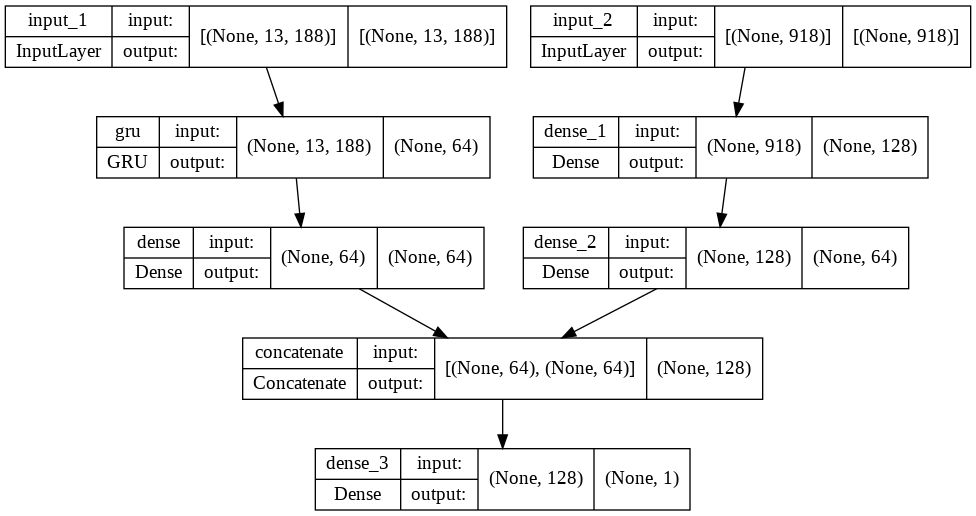

In [31]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file="/tmp/model.png", show_shapes=True)